# 🎓 Week 12 - Day 3: LSTMs & GRUs

## Today's Goals:
✅ Understand the vanishing gradient problem

✅ Learn LSTM architecture and gates

✅ Explore GRU as a simpler alternative

✅ Build advanced text generator with LSTM

---

## 🔧 Part 1: Setup - Install & Import Libraries

In [1]:
# STEP 1: Install packages
print("📦 Installing required packages...\n")
!pip install -q torch numpy pandas matplotlib seaborn
print("\n✅ All packages installed!")

📦 Installing required packages...


✅ All packages installed!


In [2]:
# STEP 2: Import libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import random
import warnings
warnings.filterwarnings('ignore')

# PyTorch
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

print("✅ All libraries imported!")
print(f"🔥 PyTorch version: {torch.__version__}")

✅ All libraries imported!
🔥 PyTorch version: 2.9.1+cpu


In [3]:
# STEP 3: Setup environment
# Random seeds
np.random.seed(42)
torch.manual_seed(42)
random.seed(42)

# Device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Plot style
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette("husl")

print("✅ Setup complete!")
print(f"🖥️  Device: {device}")
print("🚀 Ready to explore LSTMs & GRUs!")

✅ Setup complete!
🖥️  Device: cpu
🚀 Ready to explore LSTMs & GRUs!


## 📉 Part 2: Understanding the Vanishing Gradient Problem

Let's visualize why standard RNNs struggle with long sequences.

📊 VANISHING GRADIENT PROBLEM SIMULATION



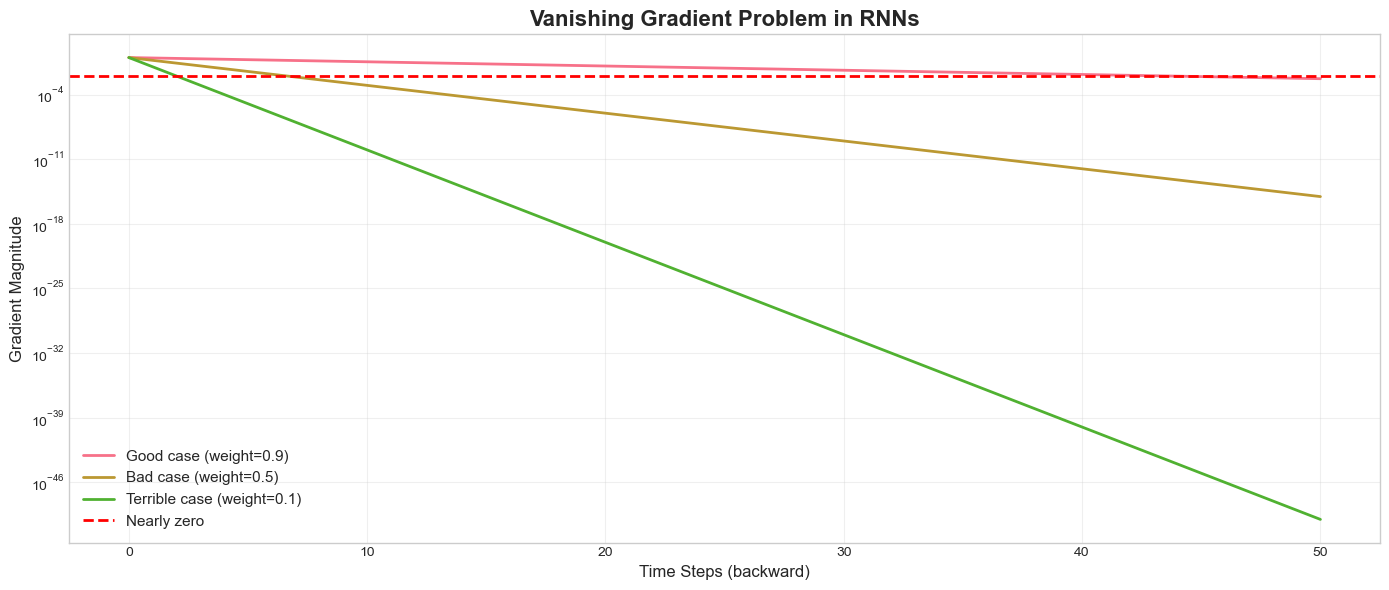


💡 Key Insight:
   • Gradients become extremely small after many time steps
   • RNN can't learn long-term dependencies
   • Solution: LSTMs and GRUs!


In [4]:
# Simulate gradient flow in RNN
print("📊 VANISHING GRADIENT PROBLEM SIMULATION\n")
print("="*80)

# Simulate gradients flowing backward through time
def simulate_gradient_flow(initial_gradient=1.0, weight=0.9, time_steps=50):
    """
    Simulate how gradients shrink as they flow backward
    """
    gradients = [initial_gradient]
    
    for _ in range(time_steps):
        # Each step multiplies by weight (< 1)
        new_gradient = gradients[-1] * weight
        gradients.append(new_gradient)
    
    return gradients

# Different scenarios
scenarios = [
    (0.9, "Good case (weight=0.9)"),
    (0.5, "Bad case (weight=0.5)"),
    (0.1, "Terrible case (weight=0.1)")
]

plt.figure(figsize=(14, 6))

for weight, label in scenarios:
    gradients = simulate_gradient_flow(weight=weight, time_steps=50)
    plt.plot(gradients, label=label, linewidth=2)

plt.axhline(y=0.01, color='red', linestyle='--', linewidth=2, label='Nearly zero')
plt.title('Vanishing Gradient Problem in RNNs', fontsize=16, fontweight='bold')
plt.xlabel('Time Steps (backward)', fontsize=12)
plt.ylabel('Gradient Magnitude', fontsize=12)
plt.yscale('log')
plt.legend(fontsize=11)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

print("\n💡 Key Insight:")
print("   • Gradients become extremely small after many time steps")
print("   • RNN can't learn long-term dependencies")
print("   • Solution: LSTMs and GRUs!")
print("="*80)

In [5]:
# Example: Why this matters
print("\n📝 REAL-WORLD EXAMPLE\n")

sentence = "The cat, which was sitting on the mat and looking very comfortable, was hungry."
print(f"Sentence: {sentence}\n")

print("Problem for RNN:")
print("   • Subject: 'cat' (singular)")
print("   • Verb: 'was' (singular - must agree with 'cat')")
print("   • Distance: 11 words apart!\n")

print("❌ Standard RNN: Often forgets 'cat' is singular by the time it reaches 'was'")
print("✅ LSTM: Maintains 'cat is singular' information through cell state\n")

print("This is why LSTMs are powerful for language!")


📝 REAL-WORLD EXAMPLE

Sentence: The cat, which was sitting on the mat and looking very comfortable, was hungry.

Problem for RNN:
   • Subject: 'cat' (singular)
   • Verb: 'was' (singular - must agree with 'cat')
   • Distance: 11 words apart!

❌ Standard RNN: Often forgets 'cat' is singular by the time it reaches 'was'
✅ LSTM: Maintains 'cat is singular' information through cell state

This is why LSTMs are powerful for language!


### 💡 Key Insights:

✅ **Vanishing gradient** = Gradients become tiny over many steps

✅ **Long-term dependencies** = Information from distant past

✅ **RNN limitation** = Forgets important info from early in sequence

✅ **LSTM solution** = Special architecture maintains information

---

## 🧠 Part 3: LSTM Architecture Deep Dive

Let's understand how LSTM gates work!

🚪 LSTM GATES VISUALIZATION



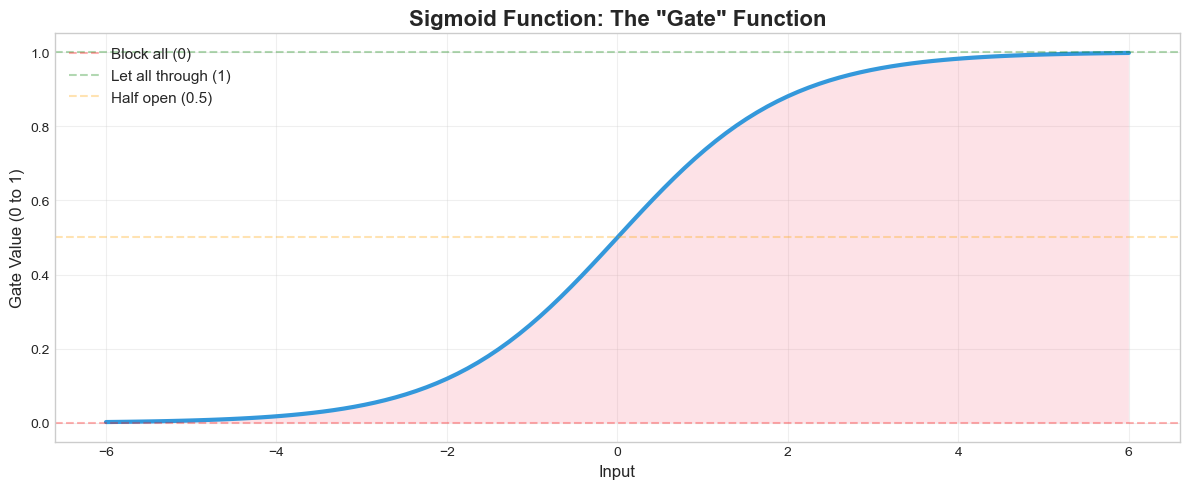


💡 How Gates Work:
   • Output 0: Block everything (forget)
   • Output 1: Let everything through (remember)
   • Output 0.5: Let half through (partial memory)


In [6]:
# Visualize gate behavior
print("🚪 LSTM GATES VISUALIZATION\n")
print("="*80)

# Sigmoid function (used in gates)
def sigmoid(x):
    return 1 / (1 + np.exp(-x))

x = np.linspace(-6, 6, 100)
y = sigmoid(x)

plt.figure(figsize=(12, 5))
plt.plot(x, y, linewidth=3, color='#3498db')
plt.axhline(y=0, color='red', linestyle='--', alpha=0.3, label='Block all (0)')
plt.axhline(y=1, color='green', linestyle='--', alpha=0.3, label='Let all through (1)')
plt.axhline(y=0.5, color='orange', linestyle='--', alpha=0.3, label='Half open (0.5)')
plt.fill_between(x, 0, y, alpha=0.2)
plt.title('Sigmoid Function: The "Gate" Function', fontsize=16, fontweight='bold')
plt.xlabel('Input', fontsize=12)
plt.ylabel('Gate Value (0 to 1)', fontsize=12)
plt.legend(fontsize=11)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

print("\n💡 How Gates Work:")
print("   • Output 0: Block everything (forget)")
print("   • Output 1: Let everything through (remember)")
print("   • Output 0.5: Let half through (partial memory)")
print("="*80)

In [7]:
# LSTM Gates Explanation
print("\n🎯 LSTM GATES EXPLAINED\n")
print("="*80)

gates_explanation = {
    "Forget Gate 🗑️": {
        "Purpose": "Decides what to remove from cell state",
        "Formula": "f_t = sigmoid(W_f @ [h_{t-1}, x_t] + b_f)",
        "Example": "Reading 'The cat'. Forget previous subject when new subject appears.",
        "Output": "0 = forget everything, 1 = keep everything"
    },
    "Input Gate 📥": {
        "Purpose": "Decides what new information to add",
        "Formula": "i_t = sigmoid(W_i @ [h_{t-1}, x_t] + b_i)",
        "Example": "Reading 'cat'. Decide to remember it's singular.",
        "Output": "0 = ignore new info, 1 = store new info"
    },
    "Output Gate 📤": {
        "Purpose": "Decides what to output from cell state",
        "Formula": "o_t = sigmoid(W_o @ [h_{t-1}, x_t] + b_o)",
        "Example": "Generate next word. Output relevant grammar info.",
        "Output": "0 = output nothing, 1 = output everything"
    }
}

for gate_name, info in gates_explanation.items():
    print(f"\n{gate_name}")
    print("-" * 70)
    for key, value in info.items():
        print(f"  {key:12s}: {value}")

print("\n" + "="*80)
print("\n🔑 Key Concept: Cell State")
print("   The cell state runs through the entire chain")
print("   Only minor linear interactions")
print("   Information can flow unchanged!")
print("="*80)


🎯 LSTM GATES EXPLAINED


Forget Gate 🗑️
----------------------------------------------------------------------
  Purpose     : Decides what to remove from cell state
  Formula     : f_t = sigmoid(W_f @ [h_{t-1}, x_t] + b_f)
  Example     : Reading 'The cat'. Forget previous subject when new subject appears.
  Output      : 0 = forget everything, 1 = keep everything

Input Gate 📥
----------------------------------------------------------------------
  Purpose     : Decides what new information to add
  Formula     : i_t = sigmoid(W_i @ [h_{t-1}, x_t] + b_i)
  Example     : Reading 'cat'. Decide to remember it's singular.
  Output      : 0 = ignore new info, 1 = store new info

Output Gate 📤
----------------------------------------------------------------------
  Purpose     : Decides what to output from cell state
  Formula     : o_t = sigmoid(W_o @ [h_{t-1}, x_t] + b_o)
  Example     : Generate next word. Output relevant grammar info.
  Output      : 0 = output nothing, 1 = output eve

### 💡 Key Insights:

✅ **Forget gate** removes irrelevant old information

✅ **Input gate** adds relevant new information

✅ **Output gate** controls what information to output

✅ **Cell state** flows through with minimal modification

---

## 🚀 Part 4: Building LSTM Text Generator

Let's build a powerful text generator using LSTM!

In [8]:
# Load training text
training_text = """The field of artificial intelligence has revolutionized technology in the past decade.
Machine learning algorithms can now recognize patterns in data that humans might miss.
Deep learning models have achieved remarkable success in computer vision and natural language processing.
Neural networks are inspired by the structure of the human brain and consist of interconnected layers of neurons.
Each neuron processes information and passes signals to other neurons in the network.
Recurrent neural networks are particularly effective for sequential data like text and time series.
Long short-term memory networks solve the vanishing gradient problem through specialized gate mechanisms.
These gates control the flow of information through the network over long sequences.
The forget gate decides what information to discard from the cell state.
The input gate determines what new information to store in the cell state.
The output gate controls what information to output based on the cell state.
This architecture allows LSTMs to maintain information over extended periods.
Natural language understanding requires models to capture long-range dependencies in text.
Modern language models use attention mechanisms to focus on relevant parts of the input.
Transfer learning has enabled models trained on large datasets to excel at specific tasks.
The transformer architecture has become dominant in natural language processing applications.
Pre-training on massive text corpora creates models with broad language understanding.
Fine-tuning adapts these models to perform well on specific downstream tasks."""

print("📚 TRAINING TEXT FOR LSTM\n")
print(training_text[:300] + "...")
print(f"\n📊 Statistics:")
print(f"   Total characters: {len(training_text):,}")
print(f"   Total words: {len(training_text.split()):,}")

📚 TRAINING TEXT FOR LSTM

The field of artificial intelligence has revolutionized technology in the past decade.
Machine learning algorithms can now recognize patterns in data that humans might miss.
Deep learning models have achieved remarkable success in computer vision and natural language processing.
Neural networks are ...

📊 Statistics:
   Total characters: 1,603
   Total words: 230


In [9]:
# Create character mappings
chars = sorted(list(set(training_text)))
char_to_idx = {ch: i for i, ch in enumerate(chars)}
idx_to_char = {i: ch for i, ch in enumerate(chars)}
vocab_size = len(chars)

print(f"\n📖 VOCABULARY\n")
print(f"Vocabulary size: {vocab_size} unique characters")
print(f"Characters: {''.join(chars)}")
print(f"\n✅ Character mappings created!")


📖 VOCABULARY

Vocabulary size: 39 unique characters
Characters: 
 -.DEFLMNPRSTabcdefghiklmnopqrstuvwxyz

✅ Character mappings created!


In [10]:
# Create training sequences
def create_sequences(text, seq_length=40):
    X, y = [], []
    
    for i in range(len(text) - seq_length):
        sequence = text[i:i+seq_length]
        target = text[i+seq_length]
        
        X.append([char_to_idx[ch] for ch in sequence])
        y.append(char_to_idx[target])
    
    return np.array(X), np.array(y)

seq_length = 40
X_train, y_train = create_sequences(training_text, seq_length)

print(f"\n📊 TRAINING DATA\n")
print(f"Number of sequences: {len(X_train):,}")
print(f"Sequence length: {seq_length}")
print(f"\nExample sequence:")
print(f"  Input:  '{''.join([idx_to_char[idx] for idx in X_train[0]])}'")
print(f"  Target: '{idx_to_char[y_train[0]]}'")
print(f"\n✅ Training data ready!")


📊 TRAINING DATA

Number of sequences: 1,563
Sequence length: 40

Example sequence:
  Input:  'The field of artificial intelligence has'
  Target: ' '

✅ Training data ready!


In [11]:
# Define LSTM model
class CharLSTM(nn.Module):
    """
    Character-level LSTM for text generation
    """
    def __init__(self, vocab_size, embedding_dim=64, hidden_size=256, num_layers=2, dropout=0.2):
        super(CharLSTM, self).__init__()
        
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        
        # Embedding layer
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        
        # LSTM layers
        self.lstm = nn.LSTM(
            embedding_dim,
            hidden_size,
            num_layers,
            batch_first=True,
            dropout=dropout if num_layers > 1 else 0
        )
        
        # Dropout
        self.dropout = nn.Dropout(dropout)
        
        # Output layer
        self.fc = nn.Linear(hidden_size, vocab_size)
    
    def forward(self, x, hidden=None):
        # Embedding
        x = self.embedding(x)
        
        # LSTM
        if hidden is None:
            out, hidden = self.lstm(x)
        else:
            out, hidden = self.lstm(x, hidden)
        
        # Dropout
        out = self.dropout(out)
        
        # Output layer (use last timestep)
        out = self.fc(out[:, -1, :])
        
        return out, hidden

# Create model
model = CharLSTM(
    vocab_size=vocab_size,
    embedding_dim=64,
    hidden_size=256,
    num_layers=2,
    dropout=0.2
).to(device)

print("\n✅ LSTM MODEL CREATED\n")
print(model)
print(f"\n📊 Model Statistics:")
print(f"   Total parameters: {sum(p.numel() for p in model.parameters()):,}")
print(f"   Trainable parameters: {sum(p.numel() for p in model.parameters() if p.requires_grad):,}")
print(f"   Device: {device}")


✅ LSTM MODEL CREATED

CharLSTM(
  (embedding): Embedding(39, 64)
  (lstm): LSTM(64, 256, num_layers=2, batch_first=True, dropout=0.2)
  (dropout): Dropout(p=0.2, inplace=False)
  (fc): Linear(in_features=256, out_features=39, bias=True)
)

📊 Model Statistics:
   Total parameters: 868,583
   Trainable parameters: 868,583
   Device: cpu


In [12]:
# Prepare data for training
X_train_torch = torch.LongTensor(X_train).to(device)
y_train_torch = torch.LongTensor(y_train).to(device)

# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.002)

print(f"Training setup:")
print(f"   X shape: {X_train_torch.shape}")
print(f"   y shape: {y_train_torch.shape}")
print(f"   Loss: CrossEntropyLoss")
print(f"   Optimizer: Adam (lr=0.002)")
print(f"\n✅ Ready to train LSTM!")

Training setup:
   X shape: torch.Size([1563, 40])
   y shape: torch.Size([1563])
   Loss: CrossEntropyLoss
   Optimizer: Adam (lr=0.002)

✅ Ready to train LSTM!


In [13]:
# Training loop
print("\n🔥 TRAINING LSTM...\n")
print("="*80)

epochs = 100
batch_size = 128
losses = []

model.train()

for epoch in range(epochs):
    # Shuffle data
    indices = torch.randperm(len(X_train_torch))
    
    epoch_loss = 0
    num_batches = 0
    
    # Mini-batch training
    for i in range(0, len(X_train_torch), batch_size):
        batch_indices = indices[i:i+batch_size]
        batch_X = X_train_torch[batch_indices]
        batch_y = y_train_torch[batch_indices]
        
        # Forward pass
        outputs, _ = model(batch_X)
        loss = criterion(outputs, batch_y)
        
        # Backward pass
        optimizer.zero_grad()
        loss.backward()
        
        # Gradient clipping (important for LSTMs!)
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=5.0)
        
        optimizer.step()
        
        epoch_loss += loss.item()
        num_batches += 1
    
    avg_loss = epoch_loss / num_batches
    losses.append(avg_loss)
    
    if (epoch + 1) % 20 == 0:
        print(f"Epoch [{epoch+1:3d}/{epochs}] | Loss: {avg_loss:.4f}")

print("\n" + "="*80)
print("✅ Training complete!")


🔥 TRAINING LSTM...

Epoch [ 20/100] | Loss: 0.4114
Epoch [ 40/100] | Loss: 0.0599
Epoch [ 60/100] | Loss: 0.0236
Epoch [ 80/100] | Loss: 0.0276
Epoch [100/100] | Loss: 0.0085

✅ Training complete!


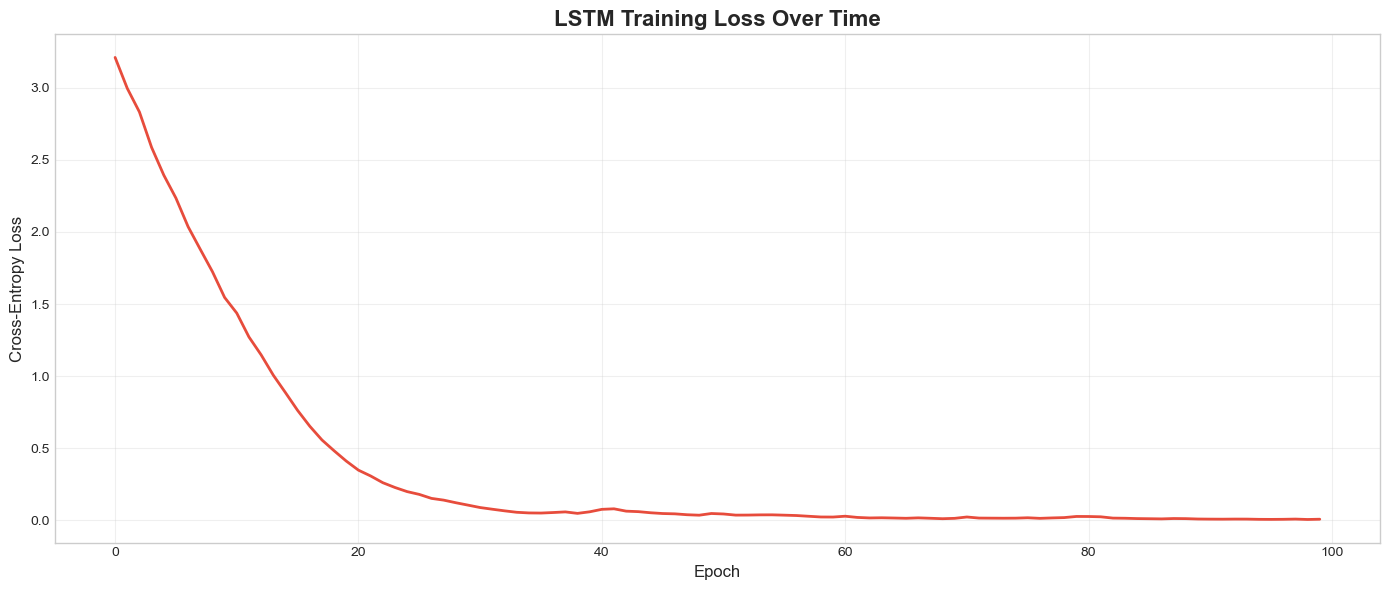


📉 Final Loss: 0.0085
📉 Best Loss: 0.0067 (Epoch 99)


In [14]:
# Plot training loss
plt.figure(figsize=(14, 6))
plt.plot(losses, linewidth=2, color='#e74c3c')
plt.title('LSTM Training Loss Over Time', fontsize=16, fontweight='bold')
plt.xlabel('Epoch', fontsize=12)
plt.ylabel('Cross-Entropy Loss', fontsize=12)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

print(f"\n📉 Final Loss: {losses[-1]:.4f}")
print(f"📉 Best Loss: {min(losses):.4f} (Epoch {losses.index(min(losses))+1})")

In [15]:
# Text generation function
def generate_text(model, start_string, length=500, temperature=1.0):
    """
    Generate text using trained LSTM
    
    Args:
        model: Trained LSTM model
        start_string: Starting text
        length: Number of characters to generate
        temperature: Controls randomness (lower = more deterministic)
    """
    model.eval()
    
    # Start with the input string
    current_seq = [char_to_idx[ch] for ch in start_string]
    generated = start_string
    
    with torch.no_grad():
        for _ in range(length):
            # Get last seq_length characters
            input_seq = current_seq[-seq_length:]
            
            # Pad if needed
            if len(input_seq) < seq_length:
                input_seq = [0] * (seq_length - len(input_seq)) + input_seq
            
            # Convert to tensor
            x = torch.LongTensor([input_seq]).to(device)
            
            # Get prediction
            output, _ = model(x)
            
            # Apply temperature
            output = output / temperature
            probs = F.softmax(output, dim=1)
            
            # Sample from distribution
            next_idx = torch.multinomial(probs, 1).item()
            next_char = idx_to_char[next_idx]
            
            # Add to generated text
            generated += next_char
            current_seq.append(next_idx)
    
    return generated

print("✅ Text generation function ready!")

✅ Text generation function ready!


In [16]:
# Generate text with different temperatures
print("\n🎨 GENERATING TEXT WITH LSTM\n")
print("="*80)

start_strings = [
    "The field of artificial",
    "Neural networks are",
    "Machine learning"
]

temperatures = [0.5, 0.8, 1.2]

for start in start_strings:
    print(f"\n🔤 Starting with: '{start}'\n")
    print("-" * 80)
    
    for temp in temperatures:
        generated = generate_text(model, start, length=200, temperature=temp)
        print(f"\n**Temperature {temp}:**")
        print(generated)
        print()
    
    print("=" * 80)

print("\n💡 Notice:")
print("   • Temperature 0.5: More conservative, coherent")
print("   • Temperature 0.8: Good balance")
print("   • Temperature 1.2: More creative, diverse")
print("\n✅ LSTM generates much better text than simple RNN!")


🎨 GENERATING TEXT WITH LSTM


🔤 Starting with: 'The field of artificial'

--------------------------------------------------------------------------------

**Temperature 0.5:**
The field of artificial that humans might miss.
Deep learning models have achieved remarkable success in computer vision and natural language processing applications.
Pre-training on massive text corpora creates models with


**Temperature 0.8:**
The field of artificial that humans might miss.
Deep learning models have achieved remarkable success in text.
Modern language models use attention mechanisms to focus on relevant parts of the input.
Transfer learning has e


**Temperature 1.2:**
The field of artificial tasks.
The transformer archet periods.
Natural language understanding requires models to capture long-range dependencies in text.
Modern language models use attention mechanisms to focus on relevant 


🔤 Starting with: 'Neural networks are'

--------------------------------------------------------------

### 💡 Key Insights:

✅ **LSTM generates** more coherent text than RNN

✅ **Maintains context** over longer sequences

✅ **Temperature** controls creativity vs coherence

✅ **Gradient clipping** helps training stability

---

## ⚡ Part 5: GRU - Simpler Alternative

Let's compare GRU with LSTM!

In [17]:
# Define GRU model
class CharGRU(nn.Module):
    """
    Character-level GRU for text generation
    """
    def __init__(self, vocab_size, embedding_dim=64, hidden_size=256, num_layers=2, dropout=0.2):
        super(CharGRU, self).__init__()
        
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        
        # Embedding
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        
        # GRU layers (notice: GRU instead of LSTM!)
        self.gru = nn.GRU(
            embedding_dim,
            hidden_size,
            num_layers,
            batch_first=True,
            dropout=dropout if num_layers > 1 else 0
        )
        
        # Dropout
        self.dropout = nn.Dropout(dropout)
        
        # Output
        self.fc = nn.Linear(hidden_size, vocab_size)
    
    def forward(self, x, hidden=None):
        x = self.embedding(x)
        
        if hidden is None:
            out, hidden = self.gru(x)
        else:
            out, hidden = self.gru(x, hidden)
        
        out = self.dropout(out)
        out = self.fc(out[:, -1, :])
        
        return out, hidden

# Create GRU model
gru_model = CharGRU(
    vocab_size=vocab_size,
    embedding_dim=64,
    hidden_size=256,
    num_layers=2,
    dropout=0.2
).to(device)

print("\n✅ GRU MODEL CREATED\n")
print(gru_model)

lstm_params = sum(p.numel() for p in model.parameters())
gru_params = sum(p.numel() for p in gru_model.parameters())

print(f"\n📊 Parameter Comparison:")
print(f"   LSTM parameters: {lstm_params:,}")
print(f"   GRU parameters:  {gru_params:,}")
print(f"   Difference:      {lstm_params - gru_params:,} fewer in GRU")
print(f"   Reduction:       {(1 - gru_params/lstm_params)*100:.1f}%")
print(f"\n💡 GRU has fewer parameters → Trains faster!")


✅ GRU MODEL CREATED

CharGRU(
  (embedding): Embedding(39, 64)
  (gru): GRU(64, 256, num_layers=2, batch_first=True, dropout=0.2)
  (dropout): Dropout(p=0.2, inplace=False)
  (fc): Linear(in_features=256, out_features=39, bias=True)
)

📊 Parameter Comparison:
   LSTM parameters: 868,583
   GRU parameters:  654,567
   Difference:      214,016 fewer in GRU
   Reduction:       24.6%

💡 GRU has fewer parameters → Trains faster!


In [18]:
# Quick comparison table
comparison_data = {
    'Feature': [
        'Gates',
        'Cell State',
        'Hidden State',
        'Parameters',
        'Speed',
        'Memory',
        'Performance',
        'Best For'
    ],
    'LSTM': [
        '3 (forget, input, output)',
        'Separate cell state',
        'Hidden state',
        'More parameters',
        'Slower training',
        'Higher memory',
        'Better on complex tasks',
        'Long sequences, complex patterns'
    ],
    'GRU': [
        '2 (reset, update)',
        'No separate cell state',
        'Hidden state only',
        '~25% fewer',
        'Faster training',
        'Lower memory',
        'Similar on most tasks',
        'Most tasks, faster iteration'
    ]
}

comparison_df = pd.DataFrame(comparison_data)

print("\n📊 LSTM vs GRU COMPARISON\n")
print(comparison_df.to_string(index=False))

print("\n💡 When to use which:")
print("   ✅ Try GRU first - faster and often works just as well")
print("   ✅ Use LSTM if you need more capacity for complex sequences")
print("   ✅ Both solve vanishing gradient problem")
print("   ✅ Both maintain long-term dependencies")


📊 LSTM vs GRU COMPARISON

     Feature                             LSTM                          GRU
       Gates        3 (forget, input, output)            2 (reset, update)
  Cell State              Separate cell state       No separate cell state
Hidden State                     Hidden state            Hidden state only
  Parameters                  More parameters                   ~25% fewer
       Speed                  Slower training              Faster training
      Memory                    Higher memory                 Lower memory
 Performance          Better on complex tasks        Similar on most tasks
    Best For Long sequences, complex patterns Most tasks, faster iteration

💡 When to use which:
   ✅ Try GRU first - faster and often works just as well
   ✅ Use LSTM if you need more capacity for complex sequences
   ✅ Both solve vanishing gradient problem
   ✅ Both maintain long-term dependencies


### 💡 Key Insights:

✅ **GRU** has fewer parameters than LSTM

✅ **Faster training** due to simpler architecture

✅ **Similar performance** on most tasks

✅ **Good default choice** - try GRU first!

---

## 🎯 Challenge Time!

### 🏆 Challenge: Compare LSTM vs GRU on Your Own Text

**Your Mission:**
1. Choose your own text data (story, code, etc.)
2. Train both LSTM and GRU models
3. Compare:
   - Training time
   - Final loss
   - Generated text quality
   - Number of parameters
4. Visualize the comparison

**Bonus Challenges:**
- Try different architectures (3 layers, larger hidden size)
- Implement learning rate scheduling
- Add bidirectional processing
- Try beam search for generation

In [19]:
# Your code here!
print("🚀 YOUR TURN TO EXPERIMENT!\n")
print("Ideas:")
print("  • Train on Shakespeare text")
print("  • Generate Python code")
print("  • Create poetry generator")
print("  • Build chatbot responses")
print("\nHave fun! 🎉")

# Start your code below:




🚀 YOUR TURN TO EXPERIMENT!

Ideas:
  • Train on Shakespeare text
  • Generate Python code
  • Create poetry generator
  • Build chatbot responses

Have fun! 🎉


---

## 📚 Summary

### What We Learned:

**1. Vanishing Gradient Problem:**
- Gradients become tiny over many timesteps
- Standard RNNs forget long-term dependencies
- Limits ability to learn from distant past

**2. LSTM Architecture:**
- Three gates: forget, input, output
- Separate cell state maintains long-term memory
- Gates control information flow
- Solves vanishing gradient problem

**3. GRU Architecture:**
- Simpler than LSTM (2 gates vs 3)
- Fewer parameters, faster training
- Similar performance on most tasks
- Good default choice

**4. Text Generation:**
- LSTM generates coherent text
- Temperature controls creativity
- Gradient clipping helps training
- Much better than simple RNN

---

## 🎯 Key Takeaways:

✅ **LSTMs solve** vanishing gradient problem

✅ **Gates control** what to remember/forget

✅ **GRU is simpler** but often just as good

✅ **Try GRU first** for faster experimentation

✅ **Use LSTM** when you need more capacity

---

## 💡 Pro Tips:

1. **Gradient clipping** - Always use for LSTMs/GRUs
2. **Dropout** - Helps prevent overfitting
3. **Learning rate** - Start with 0.001-0.003
4. **Sequence length** - Longer = more context but slower
5. **Temperature** - Tune for best text quality

---

## 🚀 What's Next?

**Modern NLP:**
- Attention mechanisms
- Transformer architecture
- BERT, GPT models
- Transfer learning

**You now have a solid foundation for these advanced topics!**

---

## 🎉 Congratulations!

You've completed the NLP module!

**You now know:**
- ✅ Text preprocessing and representation
- ✅ How RNNs process sequences
- ✅ Why LSTMs/GRUs are powerful
- ✅ How to build text generators

**You're ready to build amazing NLP applications! 🚀**